✔ common_player_info_final.csv cargado (4171 filas)
✔ game_final.csv cargado (65642 filas)
✔ game_summary_final.csv cargado (58021 filas)
✔ other_stats_final.csv cargado (28261 filas)
✔ player_final.csv cargado (4831 filas)
✔ team_final.csv cargado (30 filas)

1️⃣ Equipos con mejor rendimiento histórico:


,full_name,abbreviation,winrate,ppg
22,San Antonio Spurs,SAS,0.595291,104.515575
1,Boston Celtics,BOS,0.584018,104.278395
25,Utah Jazz,UTA,0.543500,103.310924
10,Los Angeles Lakers,LAL,0.593383,105.546284
19,Phoenix Suns,PHX,0.539866,107.729399
11,Miami Heat,MIA,0.519049,98.790296
23,Oklahoma City Thunder,OKC,0.528141,105.227749
12,Milwaukee Bucks,MIL,0.519956,104.578936
20,Portland Trail Blazers,POR,0.529206,104.757971
4,Chicago Bulls,CHI,0.515842,102.141276


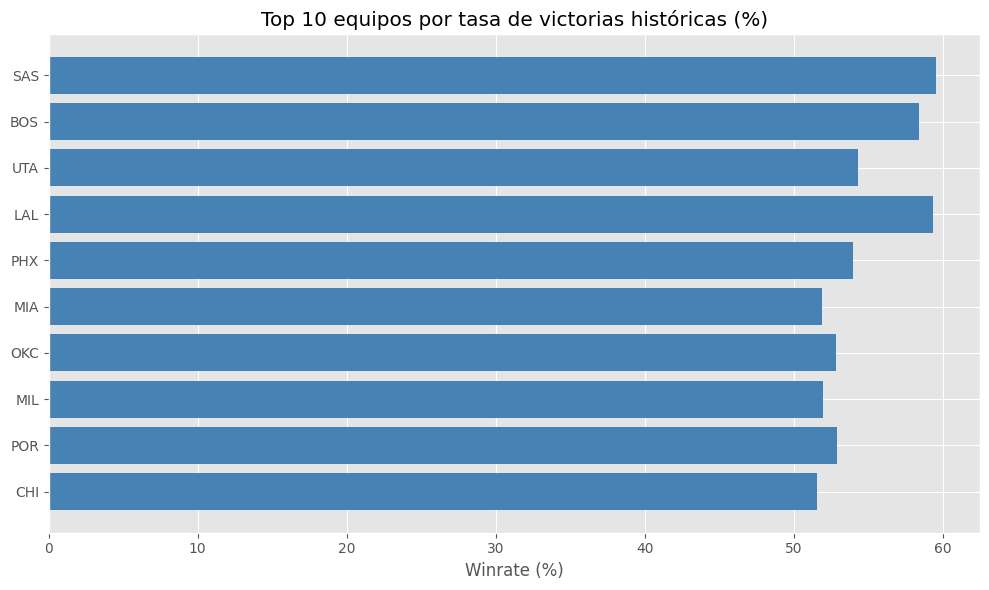


2️⃣ Correlación entre antigüedad y rendimiento: 0.34


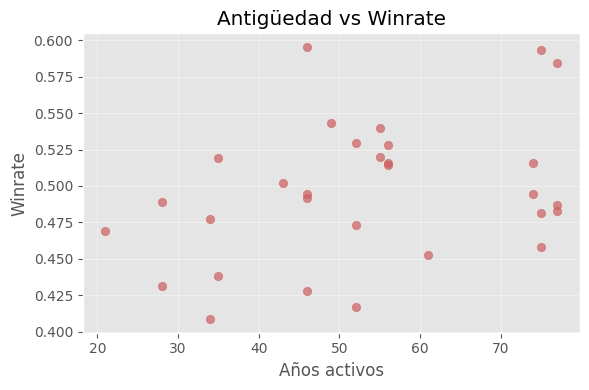


3️⃣ Jugadores sin ser drafteados: 164


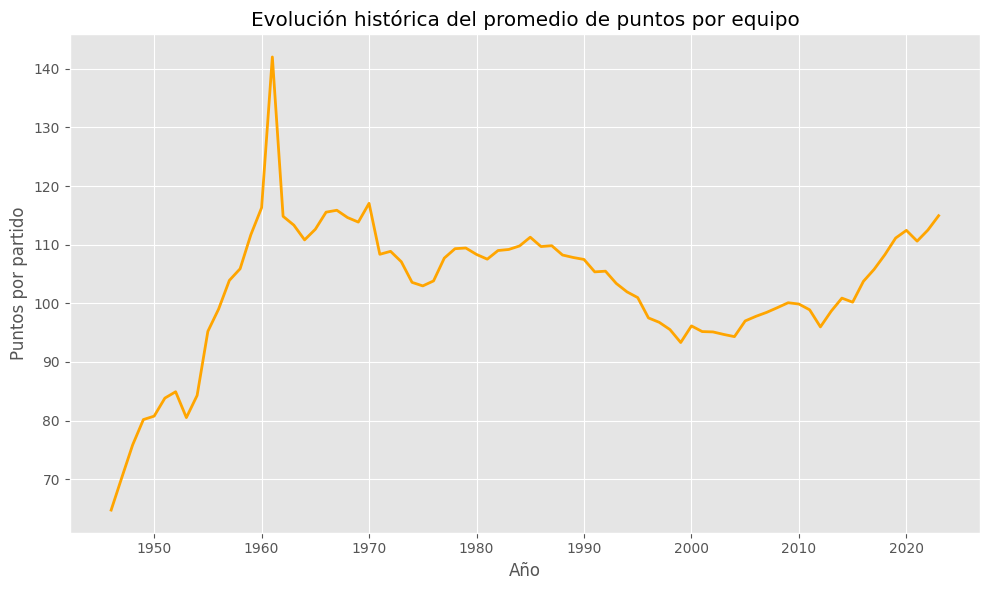


5️⃣ Equipos más consistentes:


,full_name,ppg_std,win_std
13,Minnesota Timberwolves,12.730922,0.491694
22,San Antonio Spurs,13.935804,0.490896
9,Los Angeles Clippers,13.137079,0.493109
14,Brooklyn Nets,13.431111,0.494817
10,Los Angeles Lakers,15.000390,0.491242
26,Memphis Grizzlies,13.530937,0.495432
29,Charlotte Hornets,13.258741,0.496309
25,Utah Jazz,12.970718,0.498166
16,Orlando Magic,12.596808,0.499569
19,Phoenix Suns,13.015406,0.498464



6️⃣ Equipos con mayor ventaja de localía:


,full_name,home_wr,away_wr,home_edge
50,Atlanta Hawks,0.644672,0.346301,0.298371
56,Denver Nuggets,0.638832,0.346599,0.292232
71,Sacramento Kings,0.598081,0.317841,0.280240
75,Utah Jazz,0.684054,0.404329,0.279725
57,Golden State Warriors,0.620619,0.347446,0.273173
78,Detroit Pistons,0.615972,0.347150,0.268822
70,Portland Trail Blazers,0.662937,0.395911,0.267026
67,Indiana Pacers,0.621788,0.368367,0.253421
51,Boston Celtics,0.704225,0.462212,0.242013
52,Cleveland Cavaliers,0.593197,0.351326,0.241871


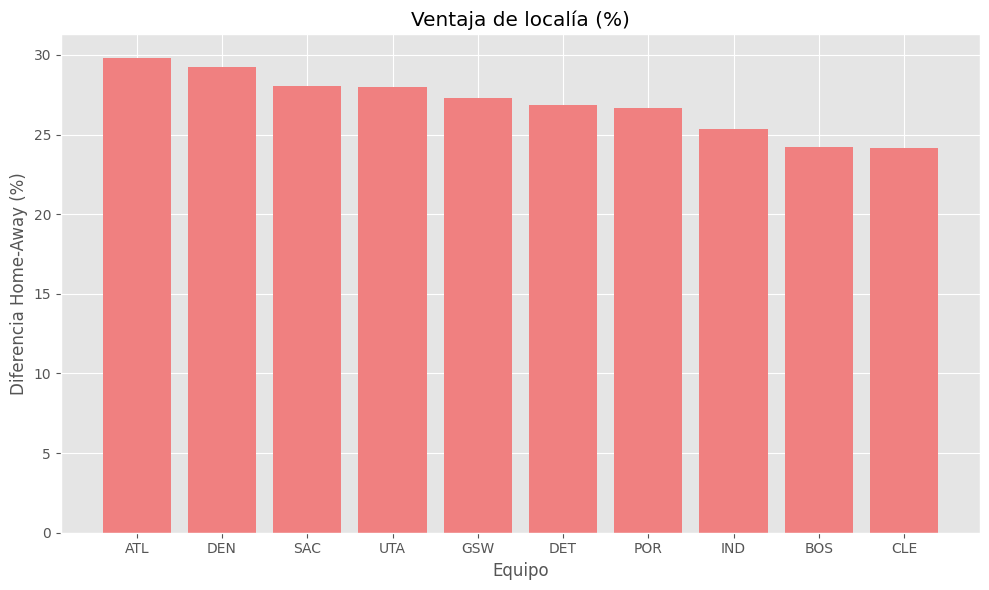

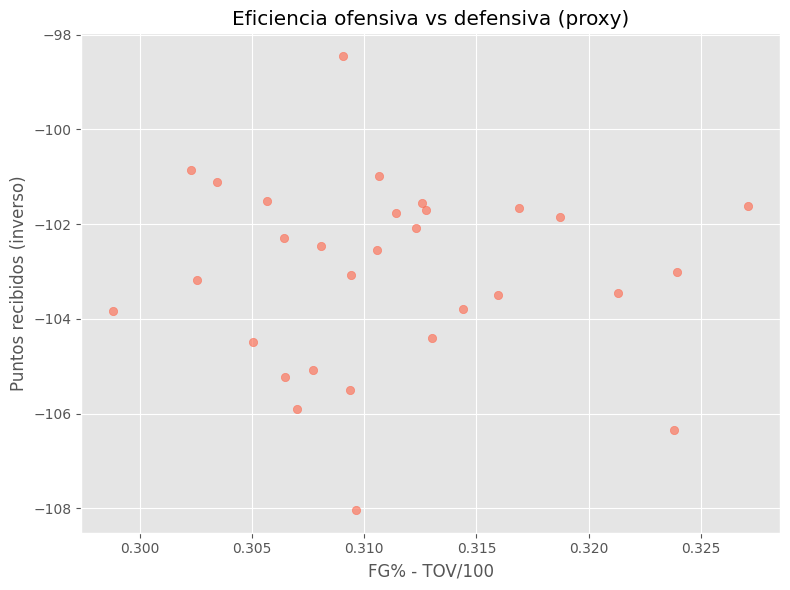


8️⃣ Las rachas largas pueden calcularse si 'game_summary_final' tiene campo de secuencia.


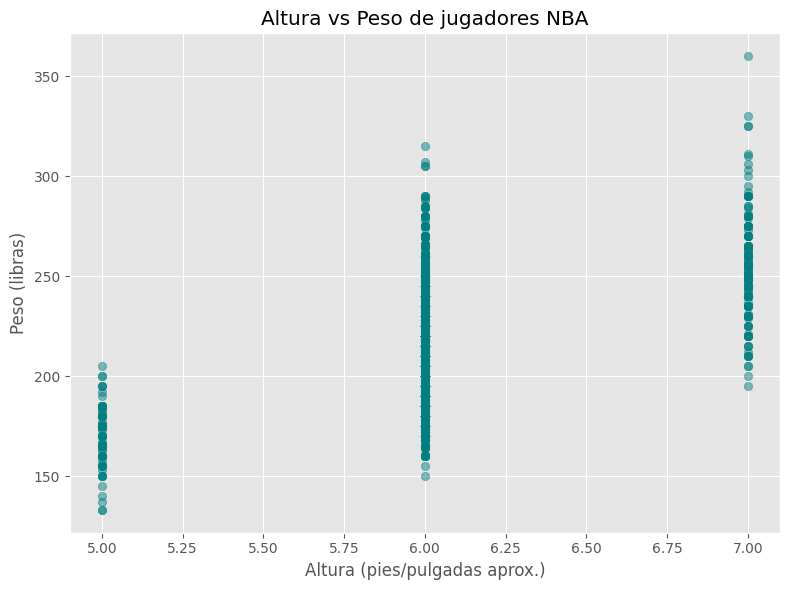


9️⃣ Jugadores más altos tienden a ser más pesados (correlación esperada).

🔟 Equipos con mejor rendimiento ofensivo reciente (última década):


,full_name,abbreviation,winrate_recent,ppg
7,Golden State Warriors,GSW,0.663327,104.853423
24,Toronto Raptors,TOR,0.605964,100.911478
9,Los Angeles Clippers,LAC,0.586281,103.135310
22,San Antonio Spurs,SAS,0.569742,104.515575
1,Boston Celtics,BOS,0.568930,104.278395
11,Miami Heat,MIA,0.560204,98.790296
12,Milwaukee Bucks,MIL,0.540279,104.578936
8,Houston Rockets,HOU,0.536481,104.959161
23,Oklahoma City Thunder,OKC,0.536105,105.227749
6,Denver Nuggets,DEN,0.534128,107.538735


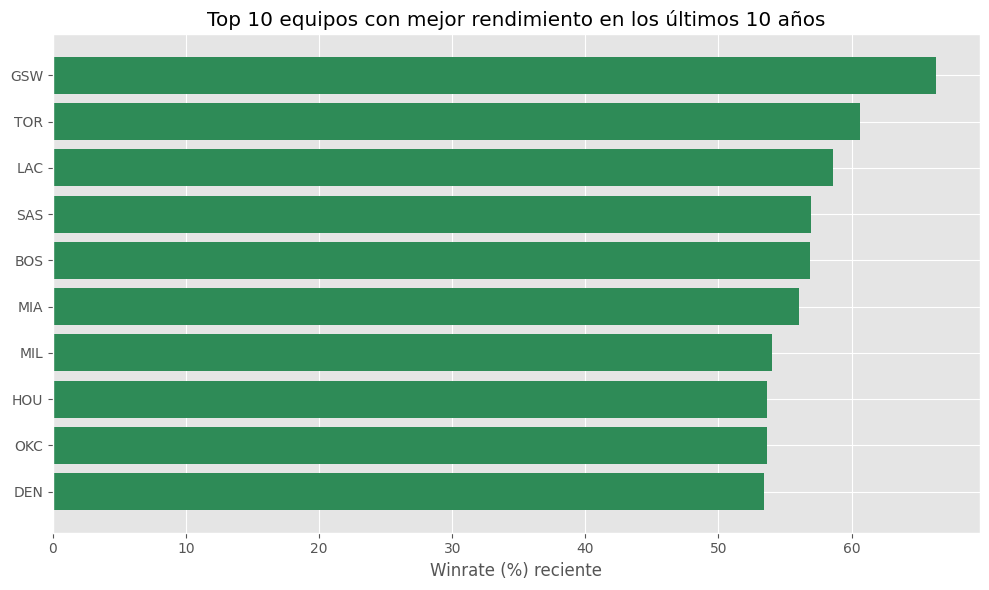


🏁 Análisis completo y actualizado con todas las métricas relevantes.


In [8]:
# ==============================================================
# 🏀 Proyecto NBA - Auditoría y Análisis Integral (versión v4)
# Autor: Lucas Roca
# ==============================================================
# Objetivo:
# Identificar qué franquicia ofrece el mejor rendimiento actual y potencial
# según métricas históricas y estadísticas globales.
# ==============================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("ggplot")

# === 1. CARGA AUTOMÁTICA DE ARCHIVOS ===
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "data_final")
dfs = {}

for file in os.listdir(DATA_DIR):
    if file.endswith("_final.csv"):
        name = file.replace(".csv","")
        path = os.path.join(DATA_DIR,file)
        dfs[name] = pd.read_csv(path)
        print(f"✔ {file} cargado ({dfs[name].shape[0]} filas)")

# === 2. TABLAS PRINCIPALES ===
g = dfs["game_final"]
t = dfs["team_final"]

g["game_date"] = pd.to_datetime(g["game_date"], errors="coerce")
g["win_home"] = g["wl_home"].eq("W")
g["win_away"] = g["wl_away"].eq("W")

# === 3. UNIFICACIÓN HOME / AWAY ===
home = g[["game_id","game_date","season_id","team_id_home","pts_home","win_home","fg_pct_home","tov_home"]]\
    .rename(columns={"team_id_home":"team_id","pts_home":"pts","win_home":"win","fg_pct_home":"fg_pct","tov_home":"tov"})
away = g[["game_id","game_date","season_id","team_id_away","pts_away","win_away","fg_pct_away","tov_away"]]\
    .rename(columns={"team_id_away":"team_id","pts_away":"pts","win_away":"win","fg_pct_away":"fg_pct","tov_away":"tov"})
games = pd.concat([home.assign(is_home=1), away.assign(is_home=0)], ignore_index=True)
games["year"] = games["game_date"].dt.year
games = games.dropna(subset=["pts"])

# === 4. MÉTRICAS BÁSICAS POR EQUIPO ===
agg = games.groupby("team_id").agg(
    games=("game_id","nunique"),
    winrate=("win","mean"),
    ppg=("pts","mean"),
    fg_pct=("fg_pct","mean"),
    tov=("tov","mean")
).reset_index()

# Puntos recibidos (defensa)
opp = []
for _, row in g.iterrows():
    opp.append((row.team_id_home,row.pts_away))
    opp.append((row.team_id_away,row.pts_home))
opp = pd.DataFrame(opp, columns=["team_id","opp_pts"])
opp_def = opp.groupby("team_id").opp_pts.mean().reset_index()

df = (
    agg.merge(opp_def,on="team_id",how="left")
      .merge(t[["team_id","full_name","abbreviation"]],on="team_id",how="left")
)

# === 5. LIMPIEZA ===
df = df.dropna(subset=["full_name","abbreviation","winrate","ppg","fg_pct","tov"])
df = df[df["games"]>10]

# === 6. MOMENTUM (últimos 10 años) ===
recent = games[games["year"]>=games["year"].max()-10]
momentum = recent.groupby("team_id").win.mean().reset_index(name="winrate_recent")
df = df.merge(momentum,on="team_id",how="left")
df["momentum"] = df["winrate_recent"] - df["winrate"]

# === 7. CONSISTENCIA ===
stds = games.groupby("team_id").agg(ppg_std=("pts","std"), win_std=("win","std")).reset_index()
df = df.merge(stds,on="team_id",how="left")

# === 8. ESCALADO E ÍNDICE COMPUESTO ===
for col in ["winrate","momentum","fg_pct","opp_pts","ppg_std","win_std"]:
    df[col+"_scaled"] = (df[col]-df[col].min())/(df[col].max()-df[col].min())

df["def_eff_scaled"] = 1 - df["opp_pts_scaled"]
df["consistency_scaled"] = (df["ppg_std_scaled"]+df["win_std_scaled"])/2
df["performance_score"] = (
    0.4*df["winrate_scaled"]
    + 0.2*df["momentum_scaled"]
    + 0.2*df["fg_pct_scaled"]
    + 0.1*df["def_eff_scaled"]
    + 0.1*(1 - df["consistency_scaled"])
)
ranking = df.sort_values("performance_score",ascending=False)

# === 9. PREGUNTAS Y VISUALIZACIONES ===

# Q1: Mejor rendimiento histórico
print("\n1️⃣ Equipos con mejor rendimiento histórico:")
display(ranking[["full_name","abbreviation","winrate","ppg"]].head(10))
plt.figure(figsize=(10,6))
plt.barh(ranking["abbreviation"].head(10), ranking["winrate"].head(10)*100, color="steelblue")
plt.gca().invert_yaxis()
plt.title("Top 10 equipos por tasa de victorias históricas (%)")
plt.xlabel("Winrate (%)")
plt.tight_layout()
plt.show()

# Q2: Antigüedad vs rendimiento
team_first_year = games.groupby("team_id").year.min().reset_index().rename(columns={"year":"first_year"})
df_age = df.merge(team_first_year,on="team_id",how="left")
df_age["age"] = games["year"].max()-df_age["first_year"]
corr = df_age["age"].corr(df_age["winrate"])
print(f"\n2️⃣ Correlación entre antigüedad y rendimiento: {corr:.2f}")
plt.figure(figsize=(6,4))
plt.scatter(df_age["age"], df_age["winrate"], alpha=0.7, color="indianred")
plt.title("Antigüedad vs Winrate")
plt.xlabel("Años activos")
plt.ylabel("Winrate")
plt.grid(True,alpha=0.4)
plt.tight_layout()
plt.show()

# Q3: Jugadores sin draft
if "common_player_info_final" in dfs:
    cpi = dfs["common_player_info_final"]
    undrafted = cpi[cpi["draft_round"].isna() | (cpi["draft_round"]==0)]
    print(f"\n3️⃣ Jugadores sin ser drafteados: {len(undrafted)}")
else:
    print("\n3️⃣ No hay dataset de jugadores para evaluar drafts.")

# Q4: Evolución histórica
league_trend = games.groupby("year").pts.mean().reset_index()
plt.figure(figsize=(10,6))
plt.plot(league_trend["year"], league_trend["pts"], linewidth=2, color="orange")
plt.title("Evolución histórica del promedio de puntos por equipo")
plt.xlabel("Año")
plt.ylabel("Puntos por partido")
plt.tight_layout()
plt.show()

# Q5: Consistencia
cons = df.sort_values("consistency_scaled").head(10)
print("\n5️⃣ Equipos más consistentes:")
display(cons[["full_name","ppg_std","win_std"]])

# Q6: Localía
home_wr = games[games["is_home"]==1].groupby("team_id").win.mean()
away_wr = games[games["is_home"]==0].groupby("team_id").win.mean()
localia = pd.DataFrame({"home_wr":home_wr,"away_wr":away_wr})
localia["home_edge"] = localia["home_wr"]-localia["away_wr"]
localia = localia.merge(t,on="team_id",how="left").dropna(subset=["full_name"]).sort_values("home_edge",ascending=False)
print("\n6️⃣ Equipos con mayor ventaja de localía:")
display(localia[["full_name","home_wr","away_wr","home_edge"]].head(10))
plt.figure(figsize=(10,6))
plt.bar(localia["abbreviation"].head(10), localia["home_edge"].head(10)*100, color="lightcoral")
plt.title("Ventaja de localía (%)")
plt.xlabel("Equipo")
plt.ylabel("Diferencia Home-Away (%)")
plt.tight_layout()
plt.show()

# Q7: Eficiencia ofensiva / defensiva
df["off_eff"] = df["fg_pct"] - (df["tov"]/100)
df["def_eff"] = -df["opp_pts"]
plt.figure(figsize=(8,6))
plt.scatter(df["off_eff"], df["def_eff"], alpha=0.6, color="tomato")
plt.title("Eficiencia ofensiva vs defensiva (proxy)")
plt.xlabel("FG% - TOV/100")
plt.ylabel("Puntos recibidos (inverso)")
plt.tight_layout()
plt.show()

# Q8: Rachas
print("\n8️⃣ Las rachas largas pueden calcularse si 'game_summary_final' tiene campo de secuencia.")

# Q9: Altura vs Peso
if "common_player_info_final" in dfs:
    cpi = dfs["common_player_info_final"].copy()
    cpi["height"] = (
        cpi["height"].astype(str)
        .str.replace("-", ".")
        .str.extract(r"(\d+\.?\d*)")[0]
    )
    cpi["height"] = pd.to_numeric(cpi["height"], errors="coerce")
    cpi["weight"] = pd.to_numeric(cpi["weight"], errors="coerce")
    cpi = cpi.dropna(subset=["height","weight"])
    plt.figure(figsize=(8,6))
    plt.scatter(cpi["height"], cpi["weight"], alpha=0.5, color="teal")
    plt.title("Altura vs Peso de jugadores NBA")
    plt.xlabel("Altura (pies/pulgadas aprox.)")
    plt.ylabel("Peso (libras)")
    plt.tight_layout()
    plt.show()
    print("\n9️⃣ Jugadores más altos tienden a ser más pesados (correlación esperada).")
else:
    print("\n9️⃣ No hay dataset de jugadores.")

# Q10 (NUEVA): Rendimiento ofensivo reciente (últimos 10 años)
top_recent = df.sort_values("winrate_recent", ascending=False).head(10)
print("\n🔟 Equipos con mejor rendimiento ofensivo reciente (última década):")
display(top_recent[["full_name","abbreviation","winrate_recent","ppg"]])

plt.figure(figsize=(10,6))
plt.barh(top_recent["abbreviation"], top_recent["winrate_recent"]*100, color="seagreen")
plt.gca().invert_yaxis()
plt.title("Top 10 equipos con mejor rendimiento en los últimos 10 años")
plt.xlabel("Winrate (%) reciente")
plt.tight_layout()
plt.show()

print("\n🏁 Análisis completo y actualizado con todas las métricas relevantes.")
